In [1]:
#########   Load the necessary library and overlays / 加载必要的库以及Overlay      ############

from PIL import Image
import numpy as np
from IPython.display import display
from pynq import Xlnk
from pynq import Overlay
from GaussianAndImage import *

import cv2 ### For cameras / 用于摄像头

Wiener_design = Overlay("./bitstream/Deblur.bit")

In [2]:
## Instantiate the IP / 实例化ip
dma = Wiener_design.axi_dma_0
Wiener = Wiener_design.WienerDeblur_0 

In [3]:
########### Camera initialization / 摄像头初始化
videoIn = cv2.VideoCapture(0)
frame_in_w = 640
frame_in_h = 480
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);

In [4]:
### Read the picture / 图片读取
def getImage(mode = 1):
    if mode == 1:#### Read image locally / 本地读取图片
        image_path = "images/4.bmp"
        original_image = Image.open(image_path)
    elif mode == 2: #### Read the picture from the camera / 从相机读取图片
        ret,frame = videoIn.read()
        original_image = Image.fromarray(np.array(frame))
    display(original_image)
    pic_width, pic_height = original_image.size
    return original_image,pic_width,pic_height

In [5]:
def bufferInitial(pic_height,pic_width,xlnk):
    
    in_buffer = xlnk.cma_array(shape=(pic_height, pic_width), 
                            dtype=np.uint8)
    out_buffer = xlnk.cma_array(shape=(pic_height, pic_width), 
                                dtype=np.uint8)
    return in_buffer,out_buffer
# in_buffer,out_buffer = bufferInitial(pic_height,pic_width)


In [6]:
def processArray(ImgArray,in_buffer,out_buffer,pic_width,pic_height):
    np.copyto(in_buffer,ImgArray)  ## Writes the image matrix to the input cache / 将图像矩阵写入输入缓存中
#     buf_image = Image.fromarray(in_buffer)   ## 缓存图像（为什么要有呢？好像可以去掉嗷）
#     display(buf_image)
    
    '''写入数据'''
    '''
    ####
    在写入图像数据流前使用MMIO接口设置resizer以及DMAIP
    ####
    '''
    Wiener.write(0x14, pic_height) #rows
    Wiener.write(0x1c, pic_width) #cols
#     Wiener.write(0x24, 20) #Data signal of threshold1
#     Wiener.write(0x2c, 100) #Data signal of threshold2

    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    
    ### Start writing the data / 开始数据的写入
    Wiener.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    #### Waiting for send and receive / 等待发送和接受
    result = Image.fromarray(out_buffer)
#    in_buffer.freebuffer()
#    out_buffer.freebuffer()
    print('result',out_buffer)
    return result
# result = processArray(nR)
# display(result)
# print("Output in Hardware(PL): {}x{} pixels.".format(pic_width, pic_height))

In [7]:
def closeBuffer(in_buffer,out_buffer):
    in_buffer.close()
    out_buffer.close()

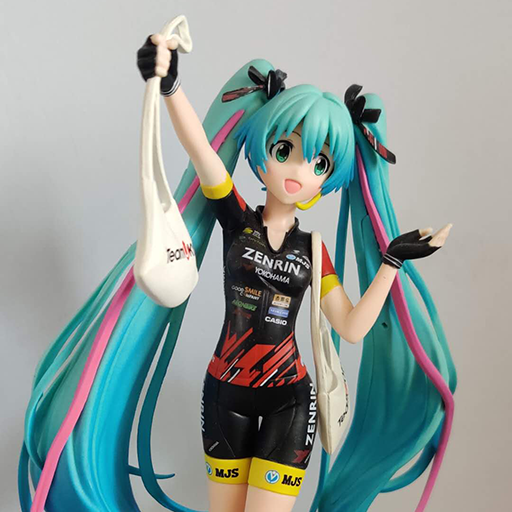

result [[208 208 208 ... 192 192 192]
 [208 208 208 ... 192 192 192]
 [210 210 210 ... 194 194 194]
 ...
 [155 157 158 ... 172 172 172]
 [157 158 160 ... 172 172 172]
 [158 160 161 ... 172 172 172]]
R计算完成
result [[210 210 210 ... 189 189 189]
 [210 210 210 ... 189 189 189]
 [212 212 212 ... 191 191 191]
 ...
 [158 159 160 ... 158 158 158]
 [159 160 162 ... 158 158 158]
 [160 162 163 ... 158 158 158]]
G计算完成
result [[209 209 209 ... 184 184 184]
 [209 209 209 ... 184 184 184]
 [211 211 211 ... 186 186 186]
 ...
 [157 158 159 ... 149 149 149]
 [158 159 161 ... 149 149 149]
 [159 161 162 ... 149 149 149]]
B计算完成


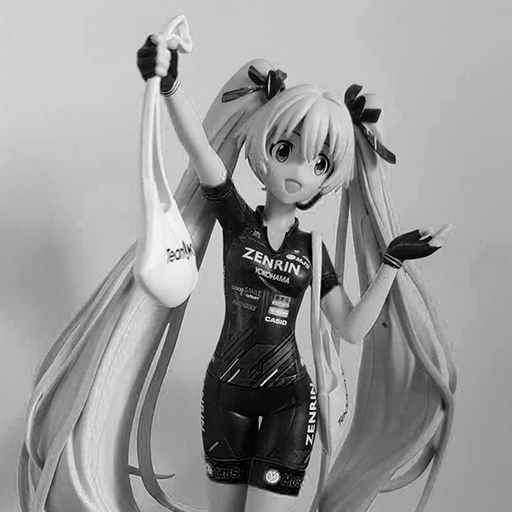

In [8]:
def main():
    ###  Complete program flow / 完整的程序流程
    original_image,pic_width,pic_height = getImage(mode = 1)
    
    xlnk = Xlnk()
    in_buffer,out_buffer = bufferInitial(pic_height,pic_width,xlnk)
    
    nR,nG,nB = Channel_partial(original_image)

    r_nR = processArray(nR,in_buffer,out_buffer,pic_width,pic_height) ### Compute channel R / 计算R通道
    print('R compute success')
    r_nG = processArray(nG,in_buffer,out_buffer,pic_width,pic_height) ### Compute channel G / 计算G通道
    print('G compute success')
    r_nB = processArray(nB,in_buffer,out_buffer,pic_width,pic_height) ### Compute channel B / 计算B通道
    print('B compute success')
    # print(np.array(r_nR) == np.array(r_nG))
    
    newImage = Channel_Compound(np.array(r_nR),np.array(r_nG),np.array(r_nB))
    display(newImage)
    newImage.show()
    closeBuffer(in_buffer,out_buffer)
    xlnk.xlnk_reset()
main()

In [27]:
na = np.array(newImage)
na.shape

NameError: name 'newImage' is not defined

In [67]:
na?

In [70]:
np.array(r_nR) == np.array(r_nG)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [75]:
dir(in_buffer)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '